In [6]:
import sys
import os
import time
import itertools
import inspect
import shutil
from IPython.display import clear_output
from tqdm.notebook import tqdm
from datetime import datetime
import json
import importlib
from typing import Any, List, Optional, Tuple, Union, Dict
import pickle
from dataclasses import dataclass, asdict
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, kstest, entropy, pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import NearestNeighbors as KNNsklearn
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from scipy.stats.stats import energy_distance
from scipy.spatial.distance import mahalanobis, cdist
import uncertainty_toolbox as uct  # https://github.com/uncertainty-toolbox/uncertainty-toolbox
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tfd = tfp.distributions
tfk = tfp.math.psd_kernels

matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["axes.grid"] = True
matplotlib.rcParams["font.size"] = 18
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["savefig.bbox"] = "tight"
# plot-settings:
ps = {
    "GP": {"c": "red", "m": "x"},
    "RF": {"c": "blue", "m": "4"},
    "BNN": {"c": "orange", "m": "v"},
    "DS": {"c": "black", "m": "*"},
    "DE": {"c": "mediumorchid", "m": "2"},
    "RS": {"c": "palegreen", "m": "h"},
}



In [12]:
@dataclass
class Parameters:
    seed: int = 0  # random seed
    dataset_name: str = "make_blobs"  # number of input dimensions
    data_dim: int = 2  # number of input dimensions
    latent_dim: int = 2  # number of latent space dimensions
    n_train: int = 100  # number of training samples
    n_test: int = 100  # number of test samples
    n_iterations: int = 1000  # number of training iterations
    gplvm_learning_rate: float = 0.001  # hyperparameter learning rate
    plot_it: bool = False  # whether to plot during BO loop
    save_it: bool = True  # whether to save progress
    gp_latent_init_pca: bool = False  # whether to initialize latent space with PCA solution
    savepth: str = os.getcwd() + "/results/"
    experiment: str = ""  # folder name

    def __init__(self, kwargs: Dict = {}, mkdir: bool = False) -> None:
        self.update(kwargs)
        if mkdir and not os.path.isdir(self.savepth):
            os.mkdir(self.savepth)
        folder_name = f"z_dim({self.latent_dim})_seed-{self.seed}"
        setattr(
            self, "experiment", folder_name,
        )
        setattr(self, "savepth", self.savepth + self.experiment + "/")
        if mkdir and not os.path.isdir(self.savepth):
            os.mkdir(self.savepth)
            self.save()

    def update(self, kwargs, save=False) -> None:
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Parameter {key} not found")
        if save:
            self.save()

    def save(self) -> None:
        json_dump = json.dumps(asdict(self))
        with open(self.savepth + "parameters.json", "w") as f:
            f.write(json_dump)

In [13]:
class Dataset(object):
    def __init__(self, parameters: Parameters) -> None:
        self.__dict__.update(asdict(parameters))
        self.generate()

    def generate(self):
        if self.dataset_name == "make_blobs":
            self.X, self.y = make_blobs(
                n_samples=self.n_train,
                n_features=self.data_dim,
                centers=2,
                cluster_std=1 / (10 * self.data_dim),
            )
            self.X = self.X.transpose()
        else:
            # Load the MNIST data set and isolate a subset of it.
            (x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
            self.X = x_train[: self.n_train, ...].astype(np.float64) / 256.0
            self.y = y_train[: self.n_train]
            self.X = self.X.reshape(self.n_train, -1).transpose()

In [27]:
class GPLVM(object):
    def __init__(self, parameters: Parameters) -> None:
        self.__dict__.update(asdict(parameters))
        np.random.seed(self.seed)
        self.trainable_variables = []
        self.init_hyperparameters()
        self.optimizer = tf.optimizers.Adam(learning_rate=self.gplvm_learning_rate)
        self.summary = {}

    def fit(self, dataset: Dataset):
        """X must be shape [D,N] """
        self.X = dataset.X
        self.y = dataset.y
        self.init_z()
        self.train()

    def init_hyperparameters(self):
        self.unconstrained_amplitude = tf.Variable(np.float64(1.0), name="amplitude")
        self.unconstrained_length_scale = tf.Variable(
            np.float64(1.0), name="length_scale"
        )
        self.unconstrained_observation_noise = tf.Variable(
            np.float64(1.0), name="observation_noise"
        )
        self.trainable_variables.append(self.unconstrained_amplitude)
        self.trainable_variables.append(self.unconstrained_length_scale)
        self.trainable_variables.append(self.unconstrained_observation_noise)

    def init_z(self):
        if self.gp_latent_init_pca:
            self.z_init = PCA(self.latent_dim).fit_transform(self.X.transpose())
        else:
            self.z_init = np.random.normal(size=(self.n_train, self.latent_dim))

        self.latent_index_points = tf.Variable(self.z_init, name="latent_index_points")
        self.trainable_variables.append(self.latent_index_points)

    def create_kernel(self) -> tf.Tensor:
        amplitude = tf.math.softplus(1e-8 + self.unconstrained_amplitude)
        length_scale = tf.math.softplus(1e-8 + self.unconstrained_length_scale)
        kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)
        return kernel

    def loss_fn(self) -> tf.Tensor:
        observation_noise_variance = tf.math.softplus(
            1e-8 + self.unconstrained_observation_noise
        )
        gp = tfd.GaussianProcess(
            kernel=self.create_kernel(),
            index_points=self.latent_index_points,
            observation_noise_variance=observation_noise_variance,
        )
        log_probs = gp.log_prob(self.X, name="log_prob")
        return -tf.reduce_mean(log_probs)

    @tf.function(autograph=False, jit_compile=True)
    def train_step(self):
        with tf.GradientTape() as tape:
            loss_value = self.loss_fn()
        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return loss_value

    def train(self):
        lips = np.zeros((self.n_iterations, self.n_train, self.latent_dim), np.float64)
        self.loss_history = np.zeros((self.n_iterations,), np.float64)
        for i in range(self.n_iterations):
            loss = self.train_step()
            lips[i] = self.latent_index_points.numpy()
            self.loss_history[i] = loss.numpy()

        self.z_final = lips[[np.argmin(self.loss_history)]].squeeze()

In [30]:
class Experiment(object):
    def __init__(self, parameters: Parameters) -> None:
        self.__dict__.update(asdict(parameters))
        self.dataset = Dataset(parameters)
        self.model = GPLVM(parameters)

    def run(self):
        self.model.fit(self.dataset)
        self.plot_learning_curve()
        self.plot_latent_space()

    def plot_learning_curve(self):
        plt.figure(figsize=(4, 4))
        plt.plot(self.model.loss_history)
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
    
    def plot_latent_space(self):
        print(self.model.z_init.shape)
        print(self.model.z_final.shape)
        # Plot the latent locations before and after training
        plt.figure(figsize=(4, 4))
        plt.title("Before training")
        plt.grid(False)
        plt.scatter(x=self.model.z_init[:, 0], y=self.model.z_init[:, 1],
                c=self.model.y, cmap=plt.get_cmap('Paired'), s=50)
        plt.xlabel(r"$z_1$")
        plt.ylabel(r"$z_2$")
        plt.show()

        plt.figure(figsize=(4, 4))
        plt.title("After training")
        plt.grid(False)
        plt.scatter(x=self.model.z_final[:, 0], y=self.model.z_final[:, 1],
                c=self.model.y, cmap=plt.get_cmap('Paired'), s=50)
        plt.xlabel(r"$z_1$")
        plt.ylabel(r"$z_2$")
        plt.show()

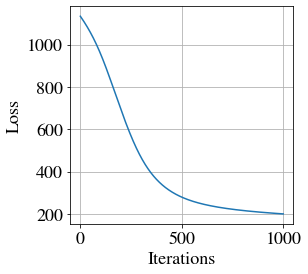

(100, 2)
(100, 2)


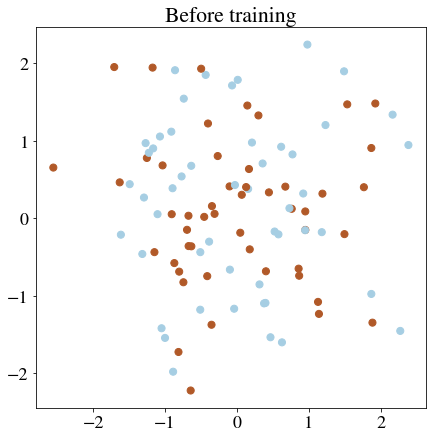

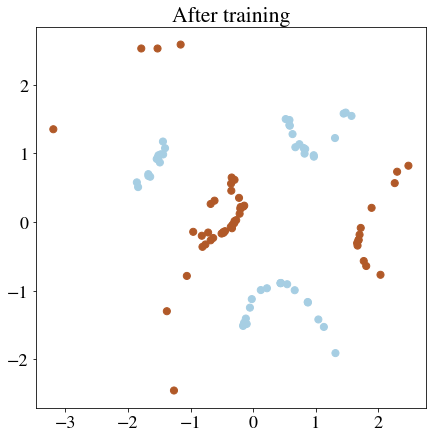

In [29]:
parameters = Parameters({"n_iterations":5000})
experiment = Experiment(parameters)
experiment.run()